# Changelog
* Use CFG for generating
* Moved the generate methods to utils
* Set `dropout` to 0.1
* Set `sample_size` to `3` -> THIS WAS WRONG THE ENTIRE TIME 😱 (update: doesn't change anything without pos. emb.)
* fixed eval_loss -> was only sampling on len/world_size samples because I used the `DistributedSampler` instead of the `RandomSampler`

In [1]:
#|default_exp train

In [2]:
# !pip install -U transformers nbdev fastcore accelerate datasets git+https://github.com/huggingface/diffusers Pillow==9.4.0 torchmetrics wandb

In [3]:
# from local_secrets import hf_token, wandb_key
# from huggingface_hub import login
# import wandb

# login(token=hf_token)
# wandb.login(key=wandb_key)

In [4]:
#|export
import torch, torch.nn.functional as F, random, wandb, time
import torchvision.transforms as T
from torchvision import transforms
from diffusers import AutoencoderDC, SanaTransformer2DModel
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler
from transformers import AutoModel, AutoTokenizer, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from tqdm import tqdm
from torch.utils.data import DataLoader, RandomSampler
from functools import partial
from types import SimpleNamespace
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel

from utils import (
    generate,
    plot_density, 
    pil_add_text, 
    latent_to_PIL, 
    make_grid, 
    fmnist_labels, 
    encode_prompt, 
    dcae_scalingf, 
    pil_clipscore, 
    free_memory, 
    get_rnd_sigmas,
    linear_multistep_coeff,
    get_sigma_schedule,
)

seed = 42
set_seed(seed)

/home/g/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [5]:
#|export
def load_models(text_encoder, transformer_config, ae, dtype, device):
    transformer = SanaTransformer2DModel.from_config(transformer_config).to(device).to(dtype)
    te = AutoModel.from_pretrained(text_encoder, torch_dtype=dtype).to(device)
    tok = AutoTokenizer.from_pretrained(text_encoder, torch_dtype=dtype)
    dcae = AutoencoderDC.from_pretrained(ae, subfolder="vae", torch_dtype=dtype).to(device)

    if debug:
        print(f"Transformer parameters: {sum(p.numel() for p in transformer.parameters()) / 1e6:.2f}M")
        print(f"DCAE parameters: {sum(p.numel() for p in dcae.parameters()) / 1e6:.2f}M")

    return transformer, te, tok, dcae

def add_random_noise(latents, dist, timesteps=1000):
    bs = latents.size(0)
    noise = torch.randn_like(latents)
    sigmas = get_rnd_sigmas(bs, dist=dist).to(latents.device)  # floats 0-1 of dist specified in train_config
    timesteps = (sigmas * timesteps).to(latents.device)   # yes, `timesteps = sigmas * 1000`, let's keep it simple
    sigmas = sigmas.view([latents.size(0), *([1] * len(latents.shape[1:]))])
    
    latents_noisy = (1 - sigmas) * latents + sigmas * noise # (1-noise_level) * latent + noise_level * noise

    return latents_noisy.to(latents.dtype), noise, timesteps

def eval_loss(dataloader_eval, testing=False):
    losses = []

    for batch_num, (labels, latents, prompts_encoded, prompts_atnmask) in tqdm(enumerate(dataloader_eval), "eval_loss"):
        latents = latents * dcae_scalingf
        latents_noisy, noise, t = add_random_noise(latents, dist=train_config.sigma_sampling)
        with torch.no_grad():
            noise_pred = transformer(latents_noisy.to(dtype), prompts_encoded, t, prompts_atnmask).sample
    
        loss = F.mse_loss(noise_pred, noise - latents)
        losses.append(loss.item())  
        if testing: break
    return sum(losses)/len(losses)

In [6]:
#|export
dtype = torch.bfloat16
device = "cuda" 
debug = True
ddp = True

model_config = SimpleNamespace(
    text_encoder = "answerdotai/ModernBERT-large",
    transformer_config = "transformer_Sana-DiT-B-MBERT-large.json",
    ae = "Efficient-Large-Model/Sana_600M_1024px_diffusers",
)

data_config = SimpleNamespace(
    dataset = "g-ronimo/IN1k-96-latents_dc-ae-f32c32-sana-1.0",
    col_label = "label",
    col_latent = "latent",
    split_train = "train",
    split_eval = "test",
    latent_shape = [1, 32, 3, 3]
)

train_config = SimpleNamespace(
    lr = 5e-4,
    bs = 1024,
    epochs = 100,
    steps_log = 10,
    steps_eval = 300,
    timesteps_training = 1000,
    sigma_sampling = "normal",  # beta uniform normal
    log_wandb = True,
    wandb_project = "Hana",
    wandb_run = "Sana-DiT-B-{size:.2f}M_{ds}_LR-{lr}_BS-{bs}_{ts_sampling}-TS-{ts}_{ws}x{device}",
)

eval_config = SimpleNamespace(
    prompts = [
        "a collection of comic books on a table",
        "a green plant with a green stem",
        "an airplane in the sky",
        "two fighter jets on the red sky",
        "a blonde girl",
        "a red car",
        "a blue car",
    ],
    seeds = [6945, 4009, 1479, 8141, 3441], # seeds for latent generation
    inference_config = dict(
        num_steps = 20, 
        guidance_scale = 2,
        latent_dim = data_config.latent_shape
    )
)

In [7]:
#|export

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

class ImageNet96Dataset(torch.utils.data.Dataset):
    def __init__(self, hf_ds, text_enc, tokenizer, bs, ddp, col_label="label", col_latent="latent"):
        self.hf_ds=hf_ds
        self.col_label, self.col_latent = col_label, col_latent
        self.text_enc, self.tokenizer =  text_enc, tokenizer
        self.tokenizer.padding_side = "right"
        self.prompt_len = 50
        
        if ddp: 
            self.sampler = DistributedSampler(hf_ds, shuffle = True, seed = seed)
        else: 
            self.sampler = RandomSampler(hf_ds, generator = torch.manual_seed(seed))
        self.dataloader = DataLoader(
            hf_ds, sampler=self.sampler, collate_fn=self.collate, batch_size=bs, num_workers=4, prefetch_factor=2
        )

    def collate(self, items):
        labels = [i[self.col_label] for i in items]
        # [B, 32, 3, 3]
        latents = torch.Tensor([i[self.col_latent] for i in items]).squeeze()
        # # pick random augmentation -> [B, num_aug, 32, 3, 2]
        # latents = latents[:, random.randint(0,3)].to(dtype)
        
        return labels, latents
        
    def __iter__(self):
        for labels, latents in self.dataloader:
            label_embs, label_atnmasks = self.encode_prompts(labels)
            latents = latents.to(dtype).to(device)
            yield labels, latents, label_embs, label_atnmasks
    
    def encode_prompts(self, prompts):
        prompts_tok = self.tokenizer(
            prompts, padding="max_length", truncation=True, max_length=self.prompt_len, return_tensors="pt"
        )
        with torch.no_grad():
            prompts_encoded = self.text_enc(**prompts_tok.to(self.text_enc.device))
        return prompts_encoded.last_hidden_state, prompts_tok.attention_mask

    def __len__(self):
        return len(self.dataloader)

In [8]:
# DON'T EXPORT
ddp = False

In [9]:
#|export
if ddp:
    dist.init_process_group(backend='nccl')
    is_master = dist.get_rank() == 0  
    world_size = dist.get_world_size()
    local_rank = dist.get_rank()
    torch.cuda.set_device(local_rank)
    debug = debug and is_master
else:
    # Running on single GPU or in notebook
    is_master = True
    world_size = 1
    local_rank = 0

transformer, text_encoder, tokenizer, dcae = load_models(
    text_encoder = model_config.text_encoder,
    transformer_config = model_config.transformer_config,
    ae = model_config.ae,
    dtype = dtype,
    device = device
)
if ddp:
	transformer = DistributedDataParallel(transformer, device_ids=[local_rank])
    
ds = load_dataset(data_config.dataset)

dataloader_train = ImageNet96Dataset(
    ds[data_config.split_train], text_enc=text_encoder, tokenizer=tokenizer, bs=train_config.bs, ddp=ddp
)
dataloader_eval = ImageNet96Dataset(
    # ddp = false, we want a random sampler, not the distributed samples, in any case
    ds[data_config.split_eval], text_enc=text_encoder, tokenizer=tokenizer, bs=train_config.bs, ddp=False
)

optimizer = torch.optim.AdamW(transformer.parameters(), lr=train_config.lr)

wandb_run = train_config.wandb_run.format(
    size=sum(p.numel() for p in transformer.parameters())/1e6, 
    lr=train_config.lr, 
    bs=train_config.bs, 
    ts=train_config.timesteps_training,
    ts_sampling=train_config.sigma_sampling.upper(),
    device=device,
    ds=data_config.dataset.split("/")[1].split("-")[0],
    ws=world_size,
)

steps_epoch = len(dataloader_train)
if is_master: 
    print(f"steps per epoch: {steps_epoch}")

/home/g/.local/lib/python3.10/site-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.load_config(...) followed by <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Transformer parameters: 125.27M
DCAE parameters: 312.25M
steps per epoch: 2503


W0223 14:21:30.875000 133911640278592 torch/_inductor/compile_worker/subproc_pool.py:126] SubprocPool unclean exit


Sigma distribution:


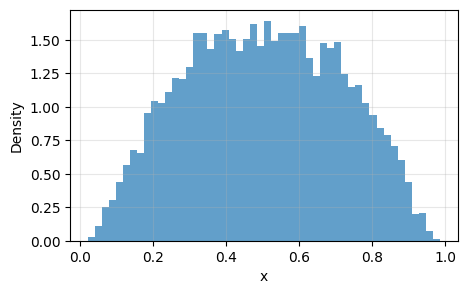

Testing noising:


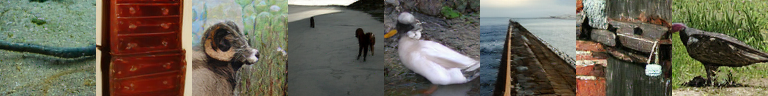

timesteps rounded [190, 869, 303, 578, 408, 312, 317, 150]


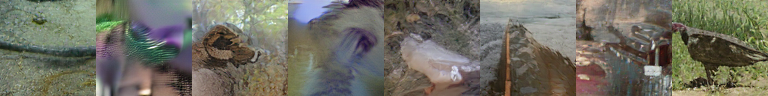

Eval prompts:
[(0, 'a collection of comic books on a table'), (1, 'a green plant with a green stem'), (2, 'an airplane in the sky'), (3, 'two fighter jets on the red sky'), (4, 'a blonde girl'), (5, 'a red car'), (6, 'a blue car')]
Inspecting first batch


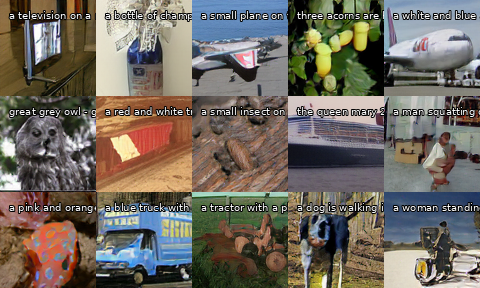

Testing generate


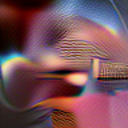

Testing eval loss


eval_loss: 0it [00:01, ?it/s]


2.203125
Testing eval images and clip score


eval_images: 100%|██████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


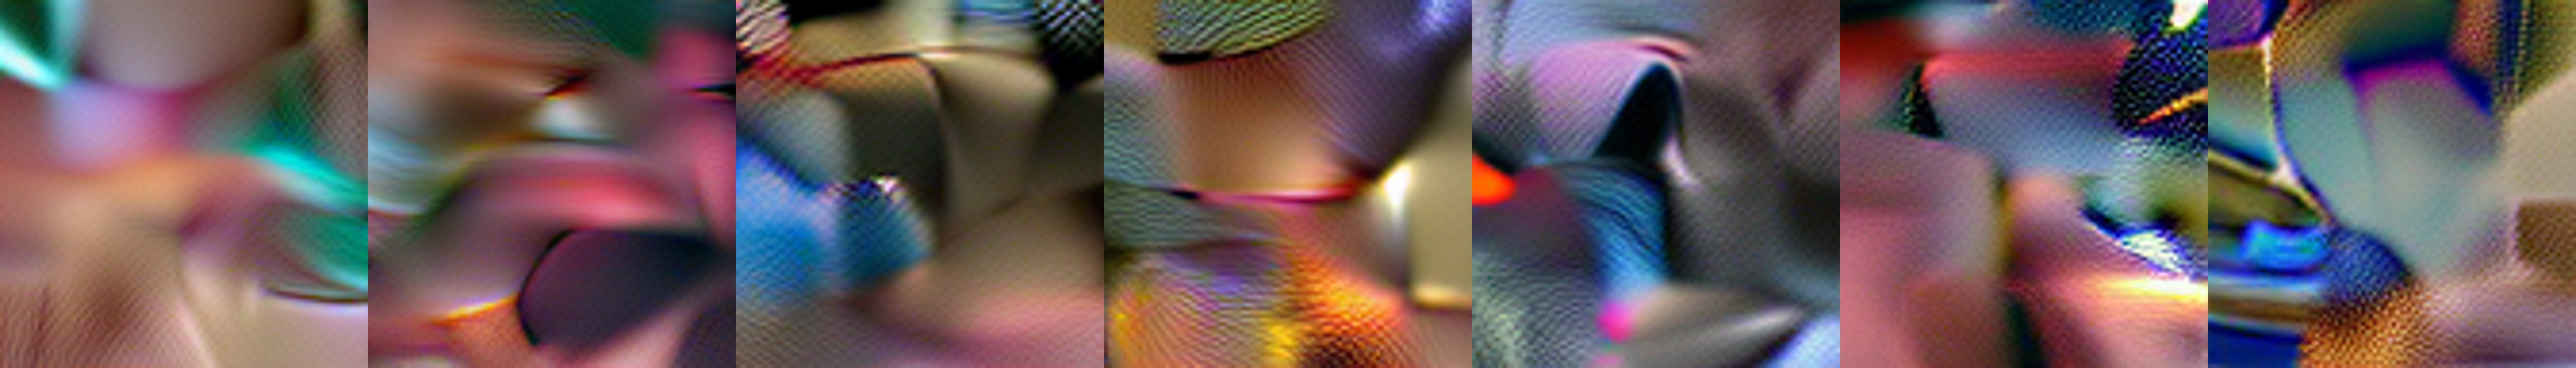

21.636449813842773


In [10]:
# DONT EXPORT
if is_master: 
    print("Sigma distribution:")
    sigmas = get_rnd_sigmas(10_000, train_config.sigma_sampling)
    plot_density(sigmas)

    print("Testing noising:")
    def test_noising():
        labels, latents, prompts_encoded, prompts_atnmask = next(iter(dataloader_train))
        # latents=latents.to(dtype).to(device)
        latent=latents[0:8,:] * dcae_scalingf
        display(make_grid(latent_to_PIL(latent / dcae_scalingf,dcae)))
        
        latent_noisy, noise, timesteps = add_random_noise(latent, dist=train_config.sigma_sampling)
        
        print("timesteps rounded", list(map(round, timesteps.tolist())))
        display(make_grid(latent_to_PIL(latent_noisy / dcae_scalingf,dcae)))
    test_noising()

    print("Eval prompts:")
    print(list(enumerate(eval_config.prompts)))
    
    print("Inspecting first batch")
    def show_first_batch(dataloader):
        labels, latents, prompts_encoded, prompts_atnmask = next(iter(dataloader))
        # latents=latents.to(dtype).to(device)
        images = [pil_add_text(latent_to_PIL(latent[None, :], dcae), str(label)) for label, latent in zip(labels[:20], latents[:20])]
        display(make_grid(images[:15], 3, 5))
    show_first_batch(dataloader_train)
    
    print("Testing generate")
    display(generate("horse", transformer, tokenizer, text_encoder, dcae, **eval_config.inference_config).resize((128,128)))
    
    print("Testing eval loss")
    print(eval_loss(dataloader_eval, testing=True))
    
    print("Testing eval images and clip score")
    images = [
        generate(p, transformer, tokenizer, text_encoder, dcae, **eval_config.inference_config) 
        for p in tqdm(eval_config.prompts, "eval_images")
    ]
    display(make_grid(images))
    print(pil_clipscore(images, eval_config.prompts))

# Train

In [13]:
import nbdev; nbdev.export.nb_export(__session__)

In [12]:
#|export

free_memory()

if is_master and train_config.log_wandb: 
    if wandb.run is not None: wandb.finish()
    wandb.init(
        project=train_config.wandb_project, 
        name=wandb_run
    ).log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb") or path.endswith(".json"))

step = 0
last_step_time = time.time()
free_memory()

for epoch in range(train_config.epochs):
    if ddp: dataloader_train.sampler.set_epoch(epoch)
    
    for labels, latents, prompts_encoded, prompts_atnmask in dataloader_train:
        latents = latents * dcae_scalingf
        latents_noisy, noise, t = add_random_noise(latents, dist = train_config.sigma_sampling)
        noise_pred = transformer(latents_noisy.to(dtype), prompts_encoded, t, prompts_atnmask).sample
        loss = F.mse_loss(noise_pred, noise - latents)
        
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()    
        
        if is_master and step>0 and step % train_config.steps_log == 0:
            loss_train = loss.item()
            step_time = (time.time() - last_step_time) / train_config.steps_log * 1000
            sample_count = step * train_config.bs * world_size
            sample_tp = train_config.bs * train_config.steps_log * world_size / (time.time() - last_step_time)
            print(f"step {step}, epoch: {step / steps_epoch:.2f}, train loss: {loss_train:.4f}, grad_norm: {grad_norm:.2f}, {step_time:.2f}ms/step, {sample_tp:.2f}samples/sec")
            if train_config.log_wandb: 
                wandb.log({"loss_train": loss_train, "grad_norm": grad_norm, "step_time": step_time, "step": step, "sample_tp": sample_tp, "sample_count": sample_count, "epoch": step / steps_epoch})
            last_step_time = time.time()

        if is_master and step>0 and step % train_config.steps_eval == 0:
                
            transformer.eval()
            loss_eval = eval_loss(dataloader_eval)
            sample_count = step * train_config.bs * world_size

            # try different seeds for generating eval images
            images_eval = [
                generate(
                    p, transformer, tokenizer, text_encoder, dcae, latent_seed=seed, **eval_config.inference_config
                ) 
                for seed in tqdm(eval_config.seeds, "eval_images")
                for p in eval_config.prompts
            ]
            clipscore = pil_clipscore(images_eval, eval_config.prompts * len(eval_config.seeds))
            # add labels before logging the images
            images_eval = make_grid([
                pil_add_text(img, eval_config.prompts[i % len(eval_config.prompts)]) 
                for i, img in enumerate(images_eval)
            ], rows=len(eval_config.seeds), cols=len(eval_config.prompts))
            print(f"step {step}, eval loss: {loss_eval:.4f}, clipscore: {clipscore:.2f}")
            if train_config.log_wandb: 
                wandb.log({"loss_eval": loss_eval, "clipscore": clipscore, "images_eval": wandb.Image(images_eval), "step": step, "sample_count": sample_count, "epoch": step / steps_epoch})
            transformer.train()        

        step += 1
        
    if ddp: transformer.module.save_pretrained(f"cp-e{epoch}")
    else: transformer.save_pretrained(f"cp-e{epoch}")

step 10, epoch: 0.00, train loss: 1.8828, grad_norm: 2.05, 619.40ms/step, 826.60samples/sec
step 20, epoch: 0.01, train loss: 1.8516, grad_norm: 1.09, 314.66ms/step, 1627.14samples/sec
step 30, epoch: 0.01, train loss: 1.8203, grad_norm: 0.68, 313.99ms/step, 1630.65samples/sec
step 40, epoch: 0.02, train loss: 1.8047, grad_norm: 0.58, 314.46ms/step, 1628.17samples/sec
step 50, epoch: 0.02, train loss: 1.7969, grad_norm: 0.44, 314.29ms/step, 1629.05samples/sec
step 60, epoch: 0.02, train loss: 1.7578, grad_norm: 0.54, 314.93ms/step, 1625.74samples/sec
step 70, epoch: 0.03, train loss: 1.7422, grad_norm: 0.38, 313.86ms/step, 1631.28samples/sec
step 80, epoch: 0.03, train loss: 1.7109, grad_norm: 0.40, 316.01ms/step, 1620.18samples/sec
step 90, epoch: 0.04, train loss: 1.7031, grad_norm: 0.60, 317.32ms/step, 1613.50samples/sec
step 100, epoch: 0.04, train loss: 1.6797, grad_norm: 0.59, 317.04ms/step, 1614.92samples/sec


eval_loss: 98it [00:22,  4.38it/s]
eval_images: 100%|██████████████████████████████████████████| 5/5 [00:18<00:00,  3.71s/it]


step 100, eval loss: 1.6725, clipscore: 20.89
step 110, epoch: 0.04, train loss: 1.6562, grad_norm: 0.39, 5163.88ms/step, 99.15samples/sec
step 120, epoch: 0.05, train loss: 1.6484, grad_norm: 0.66, 315.13ms/step, 1624.75samples/sec
step 130, epoch: 0.05, train loss: 1.6094, grad_norm: 0.52, 317.01ms/step, 1615.07samples/sec
step 140, epoch: 0.06, train loss: 1.5781, grad_norm: 0.78, 318.79ms/step, 1606.08samples/sec
step 150, epoch: 0.06, train loss: 1.5703, grad_norm: 1.01, 321.20ms/step, 1594.05samples/sec
step 160, epoch: 0.06, train loss: 1.5312, grad_norm: 0.68, 318.74ms/step, 1606.32samples/sec
step 170, epoch: 0.07, train loss: 1.4922, grad_norm: 0.55, 318.60ms/step, 1607.01samples/sec
step 180, epoch: 0.07, train loss: 1.4844, grad_norm: 0.78, 316.83ms/step, 1616.00samples/sec
step 190, epoch: 0.08, train loss: 1.4609, grad_norm: 0.53, 316.33ms/step, 1618.54samples/sec
step 200, epoch: 0.08, train loss: 1.4453, grad_norm: 0.65, 317.72ms/step, 1611.46samples/sec


eval_loss: 98it [00:22,  4.34it/s]
eval_images:  40%|████████████████▊                         | 2/5 [00:06<00:10,  3.49s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79cc980716c0>
Traceback (most recent call last):
  File "/home/g/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/home/g/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.p

KeyboardInterrupt: 

In [ ]:
#|export
if ddp: torch.distributed.barrier()

if is_master:
    wandb.finish()
    transformer.module.push_to_hub(f"g-ronimo/hana-alpha28")

if ddp: dist.destroy_process_group()